### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
%matplotlib inline

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


#pip install xlrd

### Reading in files

In [3]:
smile_on = pd.read_csv('../data/SmileOn11.28.2020.csv', sep = ',', encoding='gbk', skiprows = 2, low_memory=False)
city_info = pd.read_csv("../data/500_Cities__Local_Data_for_Better_Health__2019_release.csv")
#data_dict = pd.read_excel('../data/Data_Dictionary.xlsx')

In [43]:
#apc = pd.read_excel('../data/2020_October_Web_Addendum_A.10212020.xlsx', skiprows = 1)
#hcpcs = pd.read_excel('../data/2020_October_Web_Addendum_B.10212020.xlsx', skiprows = 2)
prov_out = pd.read_csv("../data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2017.csv", low_memory= False)
bill = pd.read_csv("../data/Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017.csv", low_memory=False)

In [44]:
prov_out.head()

,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Provider_HRR,APC,APC_Desc,Beneficiaries,CAPC_Services,Average_Total_Submitted_Charges,Average_Medicare_Allowed_Amount,Average_Medicare_Payment_Amount,Outlier_Services,Average_Medicare_Outlier_Amount
0,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,5072,Level 2 Excision/ Biopsy/ Incision and Drainage,249,259,"9,575.01","1,038.45",826.28,NaN,NaN
1,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,5073,Level 3 Excision/ Biopsy/ Incision and Drainage,52,53,"12,578.28","1,792.60","1,423.25",NaN,NaN
2,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,5091,Level 1 Breast/Lymphatic Surgery and Related P...,26,27,"11,337.61","2,113.58","1,683.99",0,0.00
3,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,5092,Level 2 Breast/Lymphatic Surgery and Related P...,23,23,"17,116.16","3,737.14","2,977.55",0,0.00
4,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,5112,Level 2 Musculoskeletal Procedures,17,17,"7,382.73","1,029.46",820.21,0,0.00


In [45]:
bill.head()

,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,100,96,100,73.3988,325.78,56.8272,57.4924
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99218,Hospital observation care typically 30 minutes,N,26,25,26,100.08,449,78.46,79.306153846
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,52,51,52,136.38,614,102.80769231,103.89538462
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99220,Hospital observation care typically 70 minutes...,N,59,59,59,190.36372881,755.93220339,141.29355932,142.86576271
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99221,"Initial hospital inpatient care, typically 30 ...",N,16,16,16,101.68,462.8125,79.71,80.75


### EDA on smile_on

In [5]:
so_1 = smile_on[['CallReportNum', 'ReportVersion',
'CallerNum', 'CityName','CountyName', 
'PostalCode','EnteredOn','Birth Year', 
'SMILE ON 60+ Screening - Last Screening Date',
'SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)',
'SMILE ON 60+ Site Information - Enroller ID', 'SMILE ON 60+ Site Information - Enroller Location', 
'SMILE ON 60+ Treatment Plan - Is the treatment plan completed?', 'SMILE ON 60+ Treatment Plan - Was a treatment plan developed?',
'SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)', 
'SMILE ON 60+ Verification of Eligibility - Transportation Arranged', 'SMILE ON 60+ Verification of Eligibility - Verification of Eligibility']]


Chaning column names

In [6]:
so_1.columns=['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName',
       'PostalCode','EnteredOn', 'BirthYear',
       'Screening - Last Screening Date',
       'Oral Care Encounter - What care was provided to the enrollee?',
       'Site Information - Enroller ID',
       'Site Information - Enroller Location',
       'Treatment Plan - Is the treatment plan completed?',
       'Treatment Plan - Was a treatment plan developed?',
       'Treatment Plan - Was the enrollee able to be restored to function',
       'Verification of Eligibility Transportation Arranged',
       'Verification of Eligibility']

In [7]:
so_1.head()

,CallReportNum,ReportVersion,CallerNum,CityName,CountyName,PostalCode,EnteredOn,BirthYear,Screening - Last Screening Date,Oral Care Encounter - What care was provided to the enrollee?,Site Information - Enroller ID,Site Information - Enroller Location,Treatment Plan - Is the treatment plan completed?,Treatment Plan - Was a treatment plan developed?,Treatment Plan - Was the enrollee able to be restored to function,Verification of Eligibility Transportation Arranged,Verification of Eligibility
0,81381827,SMILE ON 60+ Registration,3859874,Springfield,Robertson,37172.0,11/25/2020 16:48,1957,NaN,NaN,Matthew Walker Comprehensive Health Center Inc...,Provider Site,NaN,NaN,NaN,NaN,NaN
1,81379177,SMILE ON 60+ Registration,3859755,Nashville,Davidson,37212.0,11/25/2020 15:55,1943,NaN,NaN,NaN,Health Assist Office,NaN,NaN,NaN,NaN,NaN
2,81377435,SMILE ON 60+ Clinical,2518680,Rogersville,Hawkins,37857.0,11/25/2020 15:02,1957,NaN,5650 - Add tooth to existing partial denture - 30,Friends in Need Health Center - Kingsport,Provider Site,Yes,Yes,Yes,NaN,NaN
3,81375215,SMILE ON 60+ Clinical,3231923,Memphis,Shelby,38104.0,11/25/2020 14:17,1953,NaN,No Code - Denture step Mandibular: may be used...,Christ Community Health Services- Frayser,Provider Site,NaN,NaN,NaN,NaN,NaN
4,81373934,SMILE ON 60+ Clinical,-1,NaN,NaN,NaN,11/25/2020 13:58,1953,11/25/2020,NaN,Neighborhood Health - Lebanon,NaN,NaN,Yes,No,NaN,Yes


In [15]:
so_1 = so_1[(so_1['CallerNum'] != -1) & (so_1['CallerNum'] != -2)]

In [16]:
treatment_plan= so_1[so_1['Treatment Plan - Is the treatment plan completed?']=='Yes']

In [17]:
treatment_plan = treatment_plan.sort_values(by = 'EnteredOn')

In [18]:
treatment_plan_patients = treatment_plan.drop_duplicates(['CallerNum'], keep='last')

In [19]:
treatment_plan_patients.shape

(2987, 17)

In [20]:
treatment_plan_restored= treatment_plan_patients[treatment_plan_patients['Treatment Plan - Was the enrollee able to be restored to function']=='Yes']
treatment_plan_restored.shape


(2653, 17)

In [21]:
treatment_plan_patients['Treatment Plan - Was the enrollee able to be restored to function'].value_counts()

Yes    2653
No       86
Name: Treatment Plan - Was the enrollee able to be restored to function, dtype: int64

In [22]:
patients_restored= so_1[so_1['Treatment Plan - Was the enrollee able to be restored to function'].isin(['Yes','No'])]

In [23]:
patients_restored.head(2)

,CallReportNum,ReportVersion,CallerNum,CityName,CountyName,PostalCode,EnteredOn,BirthYear,Screening - Last Screening Date,Oral Care Encounter - What care was provided to the enrollee?,Site Information - Enroller ID,Site Information - Enroller Location,Treatment Plan - Is the treatment plan completed?,Treatment Plan - Was a treatment plan developed?,Treatment Plan - Was the enrollee able to be restored to function,Verification of Eligibility Transportation Arranged,Verification of Eligibility
2,81377435,SMILE ON 60+ Clinical,2518680,Rogersville,Hawkins,37857.0,11/25/2020 15:02,1957,NaN,5650 - Add tooth to existing partial denture - 30,Friends in Need Health Center - Kingsport,Provider Site,Yes,Yes,Yes,NaN,NaN
13,81360780,SMILE ON 60+ Clinical,3172525,Cleveland,Bradley,37312.0,11/25/2020 9:36,1959,2/7/2020,No Code - Denture step Mandibular: may be used...,Karis Dental Clinic - Cleveland,Provider Site,No,NaN,Yes,NaN,NaN


In [24]:
patients_restored = patients_restored.sort_values(by = 'EnteredOn')

In [25]:
patients_restored = patients_restored.drop_duplicates(['CallerNum'], keep='last')
patients_restored.shape

(4575, 17)

In [26]:
patients_restored.head(2)

,CallReportNum,ReportVersion,CallerNum,CityName,CountyName,PostalCode,EnteredOn,BirthYear,Screening - Last Screening Date,Oral Care Encounter - What care was provided to the enrollee?,Site Information - Enroller ID,Site Information - Enroller Location,Treatment Plan - Is the treatment plan completed?,Treatment Plan - Was a treatment plan developed?,Treatment Plan - Was the enrollee able to be restored to function,Verification of Eligibility Transportation Arranged,Verification of Eligibility
35116,59364969,SMILE ON 60+ Clinical,2511788,Lewisburg,Marshall,37091.0,1/10/2019 12:45,1937,1/8/2019,NaN,Interfaith Dental Clinic - Murfreesboro,Provider Site,Yes,Yes,Yes,No,Yes
35186,59355822,SMILE ON 60+ Clinical,2440677,Cleveland,Bradley,37323.0,1/10/2019 7:39,1951,NaN,No Code - Denture step Mandibular: may be used...,Karis Dental Clinic - Cleveland,Provider Site,Yes,NaN,Yes,NaN,NaN


In [27]:
patients_restored_yes = patients_restored[patients_restored["Treatment Plan - Was the enrollee able to be restored to function"]=='Yes']
patients_restored_no = patients_restored[patients_restored["Treatment Plan - Was the enrollee able to be restored to function"]=='No']

In [28]:
yes = patients_restored_yes['Site Information - Enroller ID'].value_counts().to_frame().reset_index()

In [31]:
no = patients_restored_no['Site Information - Enroller ID'].value_counts().to_frame().reset_index()

In [32]:
combo = pd.merge(yes, no, on = 'index')

In [33]:
combo['total'] = combo['Site Information - Enroller ID_x'] + combo['Site Information - Enroller ID_y']

In [34]:
combo['percentage'] = (combo['Site Information - Enroller ID_x']/combo['total'])*100

In [35]:
combo.head(2)

,index,Site Information - Enroller ID_x,Site Information - Enroller ID_y,total,percentage
0,Church Health Center - Memphis,348,169,517,67.311412
1,Interfaith Dental Clinic - Nashville,346,276,622,55.627010


In [36]:
combo.columns=['location','restored_yes','restored_no','total','percentage']

### New DF with success of restoration to function

In [37]:
combo_5 = combo.head()

In [38]:
combo_5

,location,restored_yes,restored_no,total,percentage
0,Church Health Center - Memphis,348,169,517,67.311412
1,Interfaith Dental Clinic - Nashville,346,276,622,55.627010
2,Interfaith Dental Clinic - Murfreesboro,233,195,428,54.439252
3,Healing Hands Health Center - Bristol,188,54,242,77.685950
4,Friends in Need Health Center - Kingsport,171,36,207,82.608696


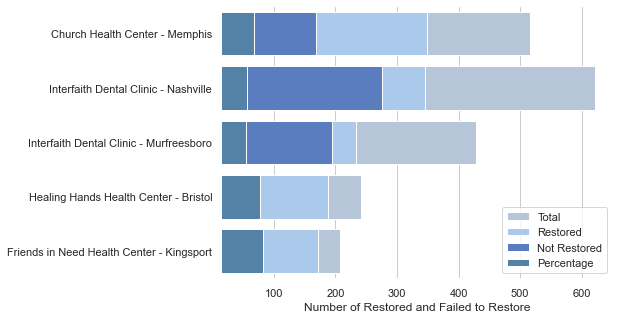

In [39]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Plot total
sns.set_color_codes("pastel")
sns.barplot(x="total", y="location", data=combo_5,
            label="Total", color="lightsteelblue")

# Plot the restored cases
sns.set_color_codes("pastel")
sns.barplot(x="restored_yes", y="location", data=combo_5,
            label="Restored", color="b")

# Plot the failed to restored cases
sns.set_color_codes("muted")
sns.barplot(x="restored_no", y="location", data=combo_5,
            label="Not Restored", color="b")

# Plot Percentage
sns.set_color_codes("muted")
sns.barplot(x="percentage", y="location", data=combo_5,
            label="Percentage", color="steelblue")

# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(15, 650), ylabel="",
       xlabel="Number of Restored and Failed to Restore")
sns.despine(left=True, bottom=True)

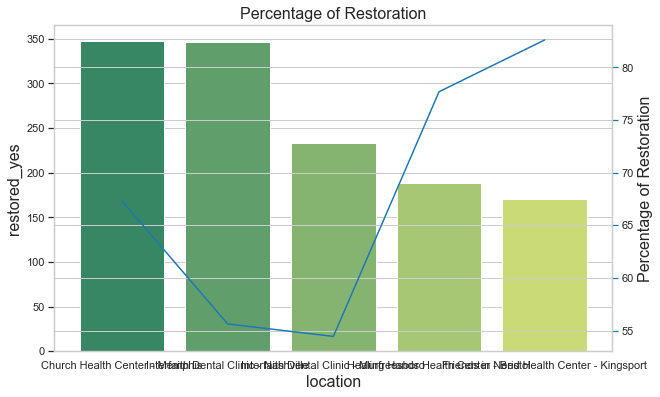

In [40]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Percentage of Restoration', fontsize=16)
ax1.set_xlabel('location', fontsize=16)
ax1.set_ylabel('restoration_yes', fontsize=16)
ax1 = sns.barplot(x='location', y='restored_yes', data = combo_5, palette='summer')
ax1.tick_params()
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
#line plot creation
ax2.set_ylabel('Percentage of Restoration', fontsize=16)
ax2 = sns.lineplot(x='location', y='percentage', data = combo_5, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()


<AxesSubplot:>

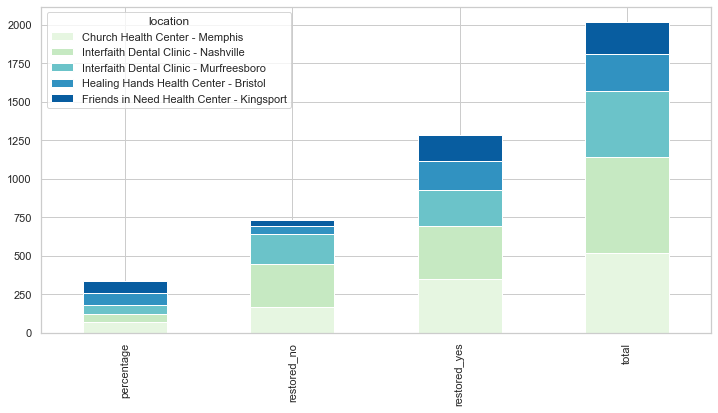

In [41]:
from matplotlib.colors import ListedColormap

combo_5.set_index('location')\
  .reindex(combo_5.set_index('location').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

In [42]:
patients_restored['Treatment Plan - Was the enrollee able to be restored to function'].value_counts()

Yes    2489
No     2086
Name: Treatment Plan - Was the enrollee able to be restored to function, dtype: int64

### End of group code

In [ ]:
#so_1['PostalCode']=np.int64(so_1['PostalCode'])

In [ ]:
#so_1[['DateEntered','Time']] = so_1.EnteredOn.str.split(" ", expand=True)


In [ ]:
#pd.to_datetime(so_1['EnteredOn'])

### EDA on city_info

In [156]:
city_info.head(1)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,GA,Georgia,Savannah,Census Tract,BRFSS,Prevention,1369000-13051004002,Visits to doctor for routine checkup within th...,%,...,75.5,NaN,NaN,"3,697","(32.0005963715, -81.1016216322)",PREVENT,CHECKUP,1369000.0,1.305100e+10,Annual Checkup


In [157]:
city_info=city_info[city_info["StateAbbr"].isin(["TN"])]
city_info.head()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
2357,2017,TN,Tennessee,Memphis,Census Tract,BRFSS,Health Outcomes,4748000-47157007300,Chronic kidney disease among adults aged >=18 ...,%,...,3.2,NaN,NaN,"4,127","(35.1209840406, -89.9363799177)",HLTHOUT,KIDNEY,4748000.0,4.715701e+10,Chronic Kidney Disease
10275,2017,TN,Tennessee,Nashville,Census Tract,BRFSS,Health Outcomes,4752006-47037018700,Stroke among adults aged >=18 Years,%,...,2.6,NaN,NaN,565,"(36.0524304194, -86.8041894006)",HLTHOUT,STROKE,4752006.0,4.703702e+10,Stroke
11053,2017,TN,Tennessee,Memphis,Census Tract,BRFSS,Unhealthy Behaviors,4748000-47157001900,Current smoking among adults aged >=18 Years,%,...,35.3,NaN,NaN,"1,601","(35.1633019396, -90.0233116647)",UNHBEH,CSMOKING,4748000.0,4.715700e+10,Current Smoking
12363,2016,TN,Tennessee,Memphis,Census Tract,BRFSS,Prevention,4748000-47157001500,Papanicolaou smear use among adult women aged ...,%,...,86.4,NaN,NaN,"1,745","(35.1529878945, -89.9740999194)",PREVENT,PAPTEST,4748000.0,4.715700e+10,Pap Smear Test
15268,2017,TN,Tennessee,Nashville,Census Tract,BRFSS,Unhealthy Behaviors,4752006-47037018102,Binge drinking among adults aged >=18 Years,%,...,13.6,NaN,NaN,"3,529","(36.1276431581, -86.8678623837)",UNHBEH,BINGE,4752006.0,4.703702e+10,Binge Drinking


In [158]:
city_info['Measure'].value_counts()

Visits to doctor for routine checkup within the past Year among adults aged >=18 Years                                                                                                            549
Chronic obstructive pulmonary disease among adults aged >=18 Years                                                                                                                                549
Mental health not good for >=14 days among adults aged >=18 Years                                                                                                                                 549
Physical health not good for >=14 days among adults aged >=18 Years                                                                                                                               549
Cholesterol screening among adults aged >=18 Years                                                                                                                                                549
Diagnosed 

In [164]:
city_teeth=city_info[city_info["Measure"].isin(["All teeth lost among adults aged >=65 Years"])]

In [182]:
city_teeth=city_teeth[city_teeth['GeographicLevel'].isin(['City'])]

In [183]:
city_teeth.head()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
46112,2016,TN,Tennessee,Memphis,City,BRFSS,Health Outcomes,4748000,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,23.1,22.5,23.7,NaN,NaN,"646,889","(35.1046295042, -89.978906085)",HLTHOUT,TEETHLOST,4748000.0,NaN,Teeth Loss
361706,2016,TN,Tennessee,Chattanooga,City,BRFSS,Health Outcomes,4714000,All teeth lost among adults aged >=65 Years,%,CrdPrv,Crude prevalence,18.5,17.5,19.4,NaN,NaN,"167,674","(35.0662472165, -85.2466771892)",HLTHOUT,TEETHLOST,4714000.0,NaN,Teeth Loss
363825,2016,TN,Tennessee,Clarksville,City,BRFSS,Health Outcomes,4715160,All teeth lost among adults aged >=65 Years,%,CrdPrv,Crude prevalence,17.3,16.2,18.4,NaN,NaN,"132,929","(36.569683159, -87.3432371614)",HLTHOUT,TEETHLOST,4715160.0,NaN,Teeth Loss
367167,2016,TN,Tennessee,Clarksville,City,BRFSS,Health Outcomes,4715160,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,17.6,16.5,18.8,NaN,NaN,"132,929","(36.569683159, -87.3432371614)",HLTHOUT,TEETHLOST,4715160.0,NaN,Teeth Loss
373771,2016,TN,Tennessee,Chattanooga,City,BRFSS,Health Outcomes,4714000,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,18.5,17.6,19.4,NaN,NaN,"167,674","(35.0662472165, -85.2466771892)",HLTHOUT,TEETHLOST,4714000.0,NaN,Teeth Loss


In [166]:
city_teeth.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'CityName', 'GeographicLevel',
       'DataSource', 'Category', 'UniqueID', 'Measure', 'Data_Value_Unit',
       'DataValueTypeID', 'Data_Value_Type', 'Data_Value',
       'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'PopulationCount',
       'GeoLocation', 'CategoryID', 'MeasureId', 'CityFIPS', 'TractFIPS',
       'Short_Question_Text'],
      dtype='object')

In [184]:
pd.set_option('display.max_columns', None)
city_teeth.head()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
46112,2016,TN,Tennessee,Memphis,City,BRFSS,Health Outcomes,4748000,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,23.1,22.5,23.7,NaN,NaN,"646,889","(35.1046295042, -89.978906085)",HLTHOUT,TEETHLOST,4748000.0,NaN,Teeth Loss
361706,2016,TN,Tennessee,Chattanooga,City,BRFSS,Health Outcomes,4714000,All teeth lost among adults aged >=65 Years,%,CrdPrv,Crude prevalence,18.5,17.5,19.4,NaN,NaN,"167,674","(35.0662472165, -85.2466771892)",HLTHOUT,TEETHLOST,4714000.0,NaN,Teeth Loss
363825,2016,TN,Tennessee,Clarksville,City,BRFSS,Health Outcomes,4715160,All teeth lost among adults aged >=65 Years,%,CrdPrv,Crude prevalence,17.3,16.2,18.4,NaN,NaN,"132,929","(36.569683159, -87.3432371614)",HLTHOUT,TEETHLOST,4715160.0,NaN,Teeth Loss
367167,2016,TN,Tennessee,Clarksville,City,BRFSS,Health Outcomes,4715160,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,17.6,16.5,18.8,NaN,NaN,"132,929","(36.569683159, -87.3432371614)",HLTHOUT,TEETHLOST,4715160.0,NaN,Teeth Loss
373771,2016,TN,Tennessee,Chattanooga,City,BRFSS,Health Outcomes,4714000,All teeth lost among adults aged >=65 Years,%,AgeAdjPrv,Age-adjusted prevalence,18.5,17.6,19.4,NaN,NaN,"167,674","(35.0662472165, -85.2466771892)",HLTHOUT,TEETHLOST,4714000.0,NaN,Teeth Loss


In [189]:
city_teeth[['CityName','Data_Value_Type','Data_Value','Low_Confidence_Limit','High_Confidence_Limit','PopulationCount','GeoLocation']]

,CityName,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation
46112,Memphis,Age-adjusted prevalence,23.1,22.5,23.7,"646,889","(35.1046295042, -89.978906085)"
361706,Chattanooga,Crude prevalence,18.5,17.5,19.4,"167,674","(35.0662472165, -85.2466771892)"
363825,Clarksville,Crude prevalence,17.3,16.2,18.4,"132,929","(36.569683159, -87.3432371614)"
367167,Clarksville,Age-adjusted prevalence,17.6,16.5,18.8,"132,929","(36.569683159, -87.3432371614)"
373771,Chattanooga,Age-adjusted prevalence,18.5,17.6,19.4,"167,674","(35.0662472165, -85.2466771892)"
378027,Nashville,Crude prevalence,15.9,15.3,16.5,"601,222","(36.1712229904, -86.7845944773)"
378544,Murfreesboro,Age-adjusted prevalence,15.4,14.1,16.9,"108,755","(35.850778195, -86.408628238)"
381788,Memphis,Crude prevalence,22.9,22.3,23.5,"646,889","(35.1046295042, -89.978906085)"
383080,Knoxville,Crude prevalence,17.2,16.3,18.2,"178,874","(35.9690594531, -83.9495877264)"
671292,Knoxville,Age-adjusted prevalence,17.1,16.3,18.1,"178,874","(35.9690594531, -83.9495877264)"


In [159]:
city_info.isnull().sum()

Year                              0
StateAbbr                         0
StateDesc                         0
CityName                          0
GeographicLevel                   0
DataSource                        0
Category                          0
UniqueID                          0
Measure                           0
Data_Value_Unit                   0
DataValueTypeID                   0
Data_Value_Type                   0
Data_Value                      667
Low_Confidence_Limit            667
High_Confidence_Limit           667
Data_Value_Footnote_Symbol    14632
Data_Value_Footnote           14632
PopulationCount                   0
GeoLocation                       0
CategoryID                        0
MeasureId                         0
CityFIPS                          0
TractFIPS                       336
Short_Question_Text               0
dtype: int64

In [ ]:
smile_

### Data for Smile_on Locations

In [154]:
#location_number,Facility,Address,Zip,City,full_address,geometry
#1,Matthew Walker Comprehensive Health Center Inc. - Nashville,1035 14th Ave N,37208,Nashville,"1035 14th Ave N, Nashville, TN 37208",POINT (-86.80084302487185 36.17025203391616)
#2,Friends in Need Health Center - Kingsport,1105 W Stone Dr # 5,37660,Kingsport,"1105 W Stone Dr # 5, Kingsport, TN 37660",POINT (-82.57384074423052 36.5585389343394)
#3,Christ Community Health Services- Frayser,969 Frayser Blvd,38127,Memphis,"969 Frayser Blvd, Memphis, TN 38127",POINT (-90.0314368977358 35.2171344409435)
#4,Neighborhood Health - Lebanon,217 E High St #200,37087,Lebanon,"217 E High St, Lebanon, TN 37087",POINT (-86.2865960042697 36.2120914257803)
#5,Christ Community Health Services- Raleigh,3481 Austin Peay Hwy,38128,Memphis,"3481 Austin Peay Hwy, Memphis, TN 38128",POINT (-89.9098503 35.22059489999999)
#6,Karis Dental Clinic - Cleveland,254 Broad St SW,37311,Cleveland,"254 Broad St SW, Cleveland, TN 37311",POINT (-84.8763672 35.1603295)
#7,Interfaith Health Clinic of Knoxville - Knoxville,315 Gill Ave,37917,Knoxville,"315 Gill Ave, Knoxville, TN 37917",POINT (-83.92318673164472 35.97956618278549)
#8,TDH - Maury Co,1909 Hampshire Pike,38401,Columbia,"1909 Hampshire Pike, Columbia, TN 38401",POINT (-87.11665865663535 35.617672592277)
#9,Knox County CAC/Office on Aging - Knoxville,2247 Western Ave,37921,Knoxville,"2247 Western Ave, Knoxville, TN 37921",POINT (-83.95758813144016 35.97349750933064)
#10,Christ Community Health Services- Broad Avenue,"2861 Broad Ave, Memphis",38112,Memphis,"2861 Broad Ave, Memphis, TN 38112",POINT (-89.965825 35.1473565)
#11,TDH - Lawrence Co,1065 East Broad Street,39654,Monticello,"2379 Buffalo Rd,  Lawrenceburg, TN 38464",POINT (-87.34165900000001 35.2727605)
#12,Church Health Center - Memphis,1350 Concourse Ave Suite 142,38104,Memphis,"1350 Concourse Ave, Memphis, TN 38104",POINT (-90.0151935387112 35.15222195)
#13,Northeast Tennessee Community Health Centers Inc. - Johnson City,2151 Century Ln,37604,Johnson City,"2151 Century Ln, Johnson City, TN 37604",POINT (-82.38793847805117 36.30841432803959)
#14,Christ Community Health Services- Hickory Hill,5366 Mendenhall Mall,38115,Memphis,"5366 Winchester Road, Memphis, TN 38115",POINT (-89.88457150843355 35.05059223197942)
#15,Matthew Walker - Clarksville,230 Dover Rd,37042,Clarksville,"230 Dover Rd, Clarksville, TN 37042",POINT (-87.39996755 36.5501441)
#16,Healing Hands Health Center - Bristol,245 Midway Medical Park,37620,Bristol,"245 Midway Medical Park, Bristol, TN 37620",POINT (-82.21868762771174 36.59431717131044)
#17,Interfaith Dental Clinic - Murfreesboro,210 Robert Rose Dr,37129,Murfreesboro,"210 Robert Rose Dr, Murfreesboro, TN 37129",POINT (-86.42861556655443 35.85340698367514)
#18,Interfaith Dental Clinic - Nashville,600 Hill Ave,37210,Nashville,"600 Hill Ave, Nashville, TN 37210",POINT (-86.7328126 36.1374736)
#19,Neighborhood Health - Napier/Nashville,107 Charles E Davis Blvd,37210,Nashville,"107 Charles E Davis Blvd, Nashville, TN 37210",POINT (-86.7621924 36.1506644)
#20,Fifty Forward - Nashville,108 Donelson Pike,37214,Nashville,"108 Donelson Pike, Nashville, TN 37214",POINT (-86.66351968015677 36.16707246874534)
#21,Mountain Hope Good Shepherd Clinic,312 Prince St,37862,Sevierville,"312 Prince St, Sevierville, TN 37862",POINT (-83.55930579299063 35.86425488114063)
#22,Neighborhood Health - Cleveland Park/ Nashville,905 Main St,37206,Nashville,"905 Main St, Nashville, TN 37206",POINT (-86.75643844444444 36.17635522222223)
#23,Christ Community Health Services- Third Street,3362 S 3rd St,38109,Memphis,"3362 S 3rd St, Memphis, TN 38109",POINT (-90.054885 35.1250516)
#24,Keystone Dental Care Inc. - Johnson City,603 Bert St # 12,37601,Johnson City,"603 Bert St # 12, Johnson City, TN 37601",POINT (-82.34012726403817 36.32141530694033)
#25,Smiles Inc. - South Pittsburg - serving Marion Grundy Franklin and Hamilton Counties,"107 E 10th St, South",37380,Pittsburg,"107 E 10th St, South Pittsburg, TN 37380",POINT (-85.71070614285715 35.00250248979592)
#26,Trinity health ministries,1127 E Lamar Alexander Pkwy,37804,Maryville,"1127 E Lamar Alexander Pkwy
#Maryville, TN 37804",POINT (-83.95506402977433 35.75510791518326)
#27,Reelfoot Ministries - Obion,6923 Minnick Elbridge Rd,38240,Obion,"6923 Minnick Elbridge Rd, Obion, TN 38240",POINT (-89.39445085774751 36.27418589319058)
#28,Neighborhood Health - Mission/Nashville,639 Lafayette St,37203,Nashville,"639 Lafayette St, Nashville, TN 37203",POINT (-86.77702071411413 36.15371975611001)
#29,Neighborhood Health - Eastside/Nashville,905 Main St,37206,Nashville,"905 Main St, Nashville, TN 37206",POINT (-86.75643844444444 36.17635522222223)
#30,Appalachian Miles for Smiles - Mobile,1105 W Stone Dr,37660,Kingsport,"1105 W Stone Dr, Kingsport, TN 37660",POINT (-82.57384074423052 36.5585389343394)
#31,Meharry Mobile Dental Clinic,1818 Albion St,37208,Nashville,"1818 Albion St, Nashville, TN 37208",POINT (-86.8080112 36.1667039)